In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import itertools
import argparse
import sys
import time
from sklearn import preprocessing
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'


Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
## Preprocessing of data
# Function to load data

def get_ghg_data():
    def splitDataset(totaldata, train = 0.8, seed = 123, normalize = True):
        # seed
        np.random.seed(seed)
        # number
        numdata = totaldata.shape[0]
        numtrain = int(numdata*train)
        numtest = numdata - numtrain
        # index
        index = np.arange(numdata)
        np.random.shuffle(index)
        # shuffle
        totaldata = totaldata[index,:,:]
        
        totaldata = totaldata.reshape(numdata, -1)
        totaldata = totaldata.T
        totaldata = totaldata/np.linalg.norm(totaldata, axis=0)
        totaldata = totaldata.T
        
        # split
        traindata = totaldata[:numtrain, :]
        testdata = totaldata[numtrain:, :]
        # split X, Y
        # train
        X_train = traindata[:,:-1]
        Y_train = traindata[:,-1].reshape(-1)

        # test
        X_test = testdata[:,:-1]
        Y_test = testdata[:,-1].reshape(-1)
        return X_train, Y_train, X_test, Y_test

    data = []
    data_folder = '/home/zehang/Downloads/dataset/ghg_data/'
    filelist = os.listdir(data_folder)
    for file in filelist:
        data_single = np.genfromtxt(data_folder+file,dtype=np.float)
        data.append(data_single)
        
    data = np.array(data)
    X_train, Y_train, X_test, Y_test = splitDataset(data)
    
    return X_train, X_test, Y_train, Y_test

In [3]:
X_train, X_test, y_train, y_test = get_ghg_data()
print("X,y types: {} {}".format(type(X_train), type(y_train)))
print("X size {}".format(X_train.shape))
print("Y size {}".format(y_train.shape))

X,y types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
X size (2336, 5231)
Y size (2336,)


In [24]:
# Sigmoid function
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x)) 
    if derivative:
        return sigm * (1. - sigm)
    return sigm

# Define weights initialization
def initialize_w(N, d):
    return 2*np.random.random((N,d)) - 1

# Fill in feed forward propagation
def feed_forward_propagation(X, y, w_1, w_2, w_3, lmbda):
    # Fill in
    # X (N,d)
    # w_1 (d,h)
    # w_2 (h,g)
    # w_3 (g,1)
    N,d = X.shape
    layer_0 = X # (N,d)
    layer_1 = sigmoid(np.dot(layer_0, w_1)) # (N, h)
    layer_2 = sigmoid(np.dot(layer_1, w_2)) # (N, g)
    layer_3 = np.dot(layer_2, w_3) # (N, 1)
    
    return layer_0, layer_1, layer_2, layer_3
def back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda):
    N = y.shape[0]
    y = y.reshape((-1,1))
    layer_3_delta = np.zeros_like(w_3) # (g,1)
    layer_2_delta = np.zeros_like(w_2) # (h, g)
    layer_1_delta = np.zeros_like(w_1) # (d, h)
    layer_3_delta = 2 * np.dot(layer_2.T, (layer_3 - y)) # (g,1)
    # print("np.dot(w_3,(layer_3-y)) shape ", np.dot(w_3,(layer_3-y).T).shape)
    # print(" sigmoid(np.dot(layer_1,w_2), derivative=True).T shape", sigmoid(np.dot(layer_1,w_2), derivative=True).T.shape)
    dJ_dl2 = 2 * np.dot(w_3,(layer_3-y).T) # # (g,N)
    dl2_ds2 = sigmoid(np.dot(layer_1,w_2), derivative=True).T # (g,N)

    layer_2_delta  = np.dot(dJ_dl2 * dl2_ds2, layer_1).T    
    # layer_2_delta = 2 * np.dot(np.dot(w_3,(layer_3-y).T)*sigmoid(np.dot(layer_1,w_2), derivative=True).T, layer_1).T
    ds2_dl1 = w_2 # (h,g)
    dl1_ds1 =  sigmoid(np.dot(layer_0,w_1), derivative=True).T # (h,N)
    ds1_dw1 = layer_0 # (N,d)

    layer_1_delta = np.dot(np.dot(ds2_dl1, dJ_dl2 * dl2_ds2) * dl1_ds1, ds1_dw1).T # (d,h)
    return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N

def back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda, activelayer = 3):
    N = y.shape[0]
    y = y.reshape((-1,1))
    layer_3_delta = np.zeros_like(w_3) # (g,1)
    layer_2_delta = np.zeros_like(w_2) # (h, g)
    layer_1_delta = np.zeros_like(w_1) # (d, h)
    layer_3_delta = 2 * np.dot(layer_2.T, (layer_3 - y)) # (g,1)
    
    if activelayer == 3:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N
    
    # print("np.dot(w_3,(layer_3-y)) shape ", np.dot(w_3,(layer_3-y).T).shape)
    # print(" sigmoid(np.dot(layer_1,w_2), derivative=True).T shape", sigmoid(np.dot(layer_1,w_2), derivative=True).T.shape)
    dJ_dl2 = 2 * np.dot(w_3,(layer_3-y).T) # # (g,N)
    dl2_ds2 = sigmoid(np.dot(layer_1,w_2), derivative=True).T # (g,N)

    layer_2_delta  = np.dot(dJ_dl2 * dl2_ds2, layer_1).T    
    if activelayer == 2:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N
    
    # layer_2_delta = 2 * np.dot(np.dot(w_3,(layer_3-y).T)*sigmoid(np.dot(layer_1,w_2), derivative=True).T, layer_1).T
    ds2_dl1 = w_2 # (h,g)
    dl1_ds1 =  sigmoid(np.dot(layer_0,w_1), derivative=True).T # (h,N)
    ds1_dw1 = layer_0 # (N,d)

    layer_1_delta = np.dot(np.dot(ds2_dl1, dJ_dl2 * dl2_ds2) * dl1_ds1, ds1_dw1).T # (d,h)
    if activelayer == 1:
        return layer_1_delta/N, layer_2_delta/N, layer_3_delta/N

# Cost function
def cost(X, y, w_1, w_2, w_3, lmbda):
    N, d = X.shape
    a1,a2,a3,a4 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)

#     return np.linalg.norm(a4[:,0] - y,2) ** 2 / N + lmbda * (np.linalg.norm(w_1)**2 + np.linalg.norm(w_2)**2 + np.linalg.norm(w_3)**2)
    return np.linalg.norm(a4[:,0] - y,2) ** 2 / N

# Define SGD
def SGD(X, y, w_1, w_2, w_3, lmbda, learning_rate, batch_size, iterations):
    # Complete here:
    loss_lst = []
    time_lst = []
    start = time.time()
    y = y.reshape((-1,1))
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        randomInd = np.arange(X.shape[0])
        np.random.shuffle(randomInd)
        randomInd = randomInd[:batch_size]
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y[randomInd,:], w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("g is ", g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            print("converge, break! current i: ", i, loss)
            break
        
        w_1 = w_1 - learning_rate*layer_1_delta
        w_2 = w_2 - learning_rate*layer_2_delta
        w_3 = w_3 - learning_rate*layer_3_delta
    
        
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)
    return w_1, w_2, w_3, loss_lst, time_lst

# Define SVRG here:
def SVRG(X, y, w_1, w_2, w_3, lmbda, learning_rate, T, batch_size, iterations):
    # Complete here:
    y = y.reshape((-1,1))
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        # compute all gradient and store
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X,y,w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3, lmbda)
            
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("g is ", g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)  
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i, loss)
            break
        
        # initialize the w_previous
        # w_previous = w.copy()
        w_1_previous, w_2_previous, w_3_previous = w_1.copy(), w_2.copy(), w_3.copy()
        for t in range(T//batch_size):
            # random sample
            # randomInd = int(np.random.rand() * N)
            randomInd = np.arange(N)
            np.random.shuffle(randomInd)
            randomInd = randomInd[:batch_size]
            # randomInd = np.random.randint(0,N)
            layer_0_p1, layer_1_p1, layer_2_p1, layer_3_p1 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1_previous,w_2_previous,w_3_previous,lmbda)
            layer_1_delta_p1, layer_2_delta_p1, layer_3_delta_p1 = back_propagation(y[randomInd,:], w_1_previous, w_2_previous, w_3_previous, layer_0_p1, layer_1_p1, layer_2_p1, layer_3_p1, lmbda)

            layer_0_p2, layer_1_p2, layer_2_p2, layer_3_p2 = feed_forward_propagation(X[randomInd,:],y[randomInd,:],w_1,w_2,w_3,lmbda)
            layer_1_delta_p2, layer_2_delta_p2, layer_3_delta_p2 = back_propagation(y[randomInd,:], w_1, w_2, w_3, layer_0_p2, layer_1_p2, layer_2_p2, layer_3_p2, lmbda)
            
            # calculate the update term
            # part1 = function_gradient_vectorization(x[:,randomInd], y[:,randomInd], w_previous, lambda_, gradclip = gradclip)
            # part2 = function_gradient_vectorization(x[:,randomInd], y[:,randomInd], w, lambda_, gradclip = gradclip)
            # part3 = g

            w_1_previous = w_1_previous - learning_rate * (layer_1_delta_p1 - layer_1_delta_p2 + layer_1_delta)
            w_2_previous = w_2_previous - learning_rate * (layer_2_delta_p1 - layer_2_delta_p2 + layer_2_delta)
            w_3_previous = w_3_previous - learning_rate * (layer_3_delta_p1 - layer_3_delta_p2 + layer_3_delta)

            # w_previous = w_previous - alpha * (part1 - part2 + part3)
            
        # w = w_previous
        
        w_1, w_2, w_3 = w_1_previous, w_2_previous, w_3_previous
        time_lst.append(time.time()-start)
        
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
    
    return w_1, w_2, w_3, loss_lst, time_lst

# Define GD here:
def GD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations):
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("g is ", g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i, loss)
            break
#         w_1 = w_1 -  learning_rate * layer_1_delta + (lmbda / N * w_1)
#         w_2 = w_2 - learning_rate * layer_2_delta + (lmbda / N * w_2)
#         w_3 = w_3 - learning_rate * layer_3_delta + (lmbda / N * w_3)
        w_1 = w_1 -  learning_rate * layer_1_delta
        w_2 = w_2 - learning_rate * layer_2_delta
        w_3 = w_3 - learning_rate * layer_3_delta
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

# Define projected GD here:
def PGD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations, noise = None):
    # Complete here:
    N = X.shape[0]
    loss_lst = []
    time_lst = []
    start = time.time()
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("g is ", g, loss)   
        if (g <= epsilon):
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            time_lst.append(time.time()-start)
            
            print("converge, break! current i: ", i,loss)
            break
            
        if noise == None:
            # the noise level is determined by the delta
            noise = []
            noise.append((np.random.random((w_1.shape)) * 2 - 1) * 0.0001)
            noise.append((np.random.random((w_2.shape)) * 2 - 1) * 0.0001)
            noise.append((np.random.random((w_3.shape)) * 2 - 1) * 0.0001)
        
        w_1 = w_1 -  learning_rate * layer_1_delta + noise[0]
        w_2 = w_2 - learning_rate * layer_2_delta + noise[1]
        w_3 = w_3 - learning_rate * layer_3_delta + noise[2]
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

# Define BCD here:
def BCD(X, y, w_1,w_2,w_3, lmbda, learning_rate, iterations, strategy = 0, blockrate = 0.5):
    loss_lst = []
    time_lst = []
    start = time.time()
    # Complete here:
    # 2 strategies:
    # a. randomly select weight by a random mask (random coordinate selection)
    # b. we train the layers asynchronously to archieve the goal of blocking coordinate (cyclic update rule) 
    for i in range(iterations):
        loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
        loss_lst.append(loss)
        
        layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
        layer_1_delta, layer_2_delta, layer_3_delta = back_propagation(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda)
        
        g = (np.linalg.norm(layer_1_delta) + np.linalg.norm(layer_2_delta) + np.linalg.norm(layer_3_delta))/3
        if i%20==0:
            print("g is ", g, loss)   
        if (g <= epsilon):
            time_lst.append(time.time()-start)
            
#             loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
            print("converge, break! current i: ", i,loss)
            break
            
        if strategy == 0:
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            # generate random mask for each layer
            l1_mask = np.random.choice([1, 0], size=layer_1_delta.shape, p=[blockrate, 1 - blockrate])
            l2_mask = np.random.choice([1, 0], size=layer_2_delta.shape, p=[blockrate, 1 - blockrate])
            l3_mask = np.random.choice([1, 0], size=layer_3_delta.shape, p=[blockrate, 1 - blockrate])
            w_1 = w_1 - learning_rate * layer_1_delta * l1_mask
            w_2 = w_2 - learning_rate * layer_2_delta * l2_mask
            w_3 = w_3 - learning_rate * layer_3_delta * l3_mask
        else:
            # cyclic
            # layer 1
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            layer_1_delta, _, _ = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 1)
            w_1 = w_1 - learning_rate * layer_1_delta
            # layer 2
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            _, layer_2_delta, _ = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 2)
            w_2 = w_2 - learning_rate * layer_2_delta
            # layer 3
            layer_0, layer_1, layer_2, layer_3 = feed_forward_propagation(X, y, w_1,w_2,w_3,lmbda)
            _, _, layer_3_delta = back_propagation_blocklayer(y, w_1, w_2, w_3, layer_0, layer_1, layer_2, layer_3,lmbda, 3)
            w_3 = w_3 - learning_rate * layer_3_delta
#         loss = cost(X_train, y_train, w_1, w_2, w_3, lmbda)
#         if i%20==0:
#             print(i,loss)
        time_lst.append(time.time()-start)

    return w_1, w_2, w_3, loss_lst, time_lst

In [30]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
lmbda =0.01
w_size = 50
lr = 0.002
iterations = 5000 # 100
T = 2000
batch_size = 100
epsilon = 0.05

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_gd = time.time()
w_1_star,w_2_star,w_3_star,loss_gd,time_gd = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_gd = time.time()
print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star,loss_pgd,time_pgd = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_sgd = time.time()
w_1_star,w_2_star,w_3_star,loss_sgd,time_sgd = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
end_sgd = time.time()
print("Training time for SGD: ", end_sgd-start_sgd)



print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_svrg = time.time()
w_1_star1,w_2_star1,w_3_star1,loss_svrg,time_svrg = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
end_svrg = time.time()
print("Training time for SVRG: ", end_svrg-start_svrg)

print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
strategy = 0 # 0 for random block mask, 1 for layer block
blockrate = 0.5
start_bcd = time.time()
w_1_star,w_2_star,w_3_star ,loss_bcd,time_bcd = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
end_bcd = time.time()
print("Training time for BCD: ", end_bcd-start_bcd)


GD	initial loss is : 1.868611418156984
g is  6.874536336836829 1.868611418156984
g is  0.5774324089661873 0.07384988538017197
g is  0.0708245609487798 0.061020792325398074
converge, break! current i:  53 0.060736635680328
Training time for GD:  6.943748235702515
PGD	initial loss is : 1.868611418156984
g is  6.874536336836829 1.868611418156984
g is  0.5605132934482354 0.07325877733342961
g is  0.05864206082607252 0.06126354469092425
converge, break! current i:  45 0.06119277418316376
Training time for PGD:  5.937990188598633
SGD	initial loss is : 1.868611418156984
g is  6.712536673678252 1.868611418156984
g is  0.48719647691472884 0.07384497407155395
converge, break! current i:  35 0.061516683672462734
Training time for SGD:  1.24947190284729
SVRG	initial loss is : 1.868611418156984
g is  6.874536336836829 1.868611418156984
converge, break! current i:  3 0.06063031412986363
Training time for SVRG:  0.7907192707061768
BCD	initial loss is : 1.868611418156984
g is  6.874536336836829 1.8686

In [51]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
lmbda =0.01
w_size = 50
lr = 0.001
iterations = 5000 # 100
T = 2000
batch_size = 100
epsilon = 0.05

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_gd = time.time()
w_1_star,w_2_star,w_3_star, loss_gd1,time_gd1 = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_gd = time.time()
print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star, loss_pgd1,time_pgd1 = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_sgd = time.time()
w_1_star,w_2_star,w_3_star, loss_sgd1,time_sgd1 = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
end_sgd = time.time()
print("Training time for SGD: ", end_sgd-start_sgd)



print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_svrg = time.time()
w_1_star1,w_2_star1,w_3_star1, loss_svrg1,time_svrg1 = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
end_svrg = time.time()
print("Training time for SVRG: ", end_svrg-start_svrg)

print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
strategy = 0 # 0 for random block mask, 1 for layer block
blockrate = 0.5
start_bcd = time.time()
w_1_star,w_2_star,w_3_star, loss_bcd1,time_bcd1 = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
end_bcd = time.time()
print("Training time for BCD: ", end_bcd-start_bcd)


GD	initial loss is : 16.40122241599924
g is  17.555043545615813 16.40122241599924
g is  7.010905329333269 2.7613265324372867
g is  2.8826752885767157 0.5027679399460668
g is  1.1967852636712386 0.11522444428538405
g is  0.4993792585561659 0.04782629628185682
g is  0.21195280995375343 0.035969493191135106
g is  0.09776713056911658 0.03380065606707523
g is  0.057188645124576866 0.033326136729828974
converge, break! current i:  149 0.03323311838232313
Training time for GD:  20.0220730304718
PGD	initial loss is : 16.40122241599924
g is  17.555043545615813 16.40122241599924
g is  6.993461831979317 2.7501955833572973
g is  2.861652026250193 0.49630898377706956
g is  1.1750286855920322 0.11167642179029316
g is  0.4773682211944808 0.04553684755406889
g is  0.18999802240286168 0.034105379969334326
g is  0.07737448515007883 0.03198264814619558
converge, break! current i:  133 0.0315466275554152
Training time for PGD:  18.451630115509033
SGD	initial loss is : 16.40122241599924
g is  17.5158080984

In [52]:
'''

    1

'''


# Should be a hyperparameter that you tune, not an argument - Fill in the values
lmbda =0.1
w_size = 50
lr = 0.001
iterations = 5000 # 100
T = 2000
batch_size = 100
epsilon = 0.05

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_gd = time.time()
w_1_star,w_2_star,w_3_star, loss_gd2, time_gd2 = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_gd = time.time()
print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star, loss_pgd2,time_pgd2 = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_sgd = time.time()
w_1_star,w_2_star,w_3_star, loss_sgd2,time_sgd2 = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
end_sgd = time.time()
print("Training time for SGD: ", end_sgd-start_sgd)



print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_svrg = time.time()
w_1_star1,w_2_star1,w_3_star2, loss_svrg2,time_svrg2 = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
end_svrg = time.time()
print("Training time for SVRG: ", end_svrg-start_svrg)

print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
strategy = 0 # 0 for random block mask, 1 for layer block
blockrate = 0.5
start_bcd = time.time()
w_1_star,w_2_star,w_3_star, loss_bcd2,time_bcd2 = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
end_bcd = time.time()
print("Training time for BCD: ", end_bcd-start_bcd)


GD	initial loss is : 3.586473875098782
g is  8.320223879906942 3.586473875098782
g is  3.5717458213226387 0.7161351355980592
g is  1.5436324654202676 0.18472040205344026
g is  0.6721993779848061 0.08545864266230493
g is  0.29952321177176844 0.06671555396263622
g is  0.14410648382842742 0.06302411367462904
g is  0.08422528993415106 0.06215146958626773
g is  0.06526491365044096 0.06180811008181927
g is  0.0606238513120102 0.06156514459325903
g is  0.059541295251998395 0.06134217631944537
g is  0.05917531685998712 0.06112412019372351
g is  0.05894615565022948 0.060908136744672756
g is  0.05874354613600414 0.06069368335530422
g is  0.0585467635766517 0.06048064840923072
g is  0.05835191755443977 0.06026900125514875
g is  0.05815827548396851 0.06005872652854443
g is  0.05796569577870649 0.059849811828596444
g is  0.057774146842625794 0.05964224540666588
g is  0.05758361731278524 0.05943601573264299
g is  0.05739409947798214 0.05923111141305763
g is  0.057205586283621955 0.059027521174860806

In [57]:
'''

    Same parameter
    
'''


# Should be a hyperparameter that you tune, not an argument - Fill in the values
lmbda =0.1
w_size = 50
lr = 0.001
iterations = 5000 # 100
T = 2000
batch_size = 100
epsilon = 0.05

# Initialize weights
w_1 = initialize_w(X_train.shape[1], w_size)

w_2 = initialize_w(w_size,w_size)

w_3 = initialize_w(w_size, 1)

print("GD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_gd = time.time()
w_1_star,w_2_star,w_3_star, loss_gd2, time_gd2 = GD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_gd = time.time()
print("Training time for GD: ", end_gd-start_gd)

print("PGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_pgd = time.time()
w_1_star,w_2_star,w_3_star, loss_pgd2,time_pgd2 = PGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations)
end_pgd = time.time()
print("Training time for PGD: ", end_pgd-start_pgd)


print("SGD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_sgd = time.time()
w_1_star,w_2_star,w_3_star, loss_sgd2,time_sgd2 = SGD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, batch_size, iterations)
end_sgd = time.time()
print("Training time for SGD: ", end_sgd-start_sgd)



print("SVRG\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
start_svrg = time.time()
w_1_star1,w_2_star1,w_3_star2, loss_svrg2,time_svrg2 = SVRG(X_train, y_train, w_1, w_2, w_3, lmbda, lr, T, batch_size, iterations)
end_svrg = time.time()
print("Training time for SVRG: ", end_svrg-start_svrg)

print("BCD\tinitial loss is :", cost(X_train, y_train, w_1, w_2, w_3, lmbda))
strategy = 0 # 0 for random block mask, 1 for layer block
blockrate = 0.5
start_bcd = time.time()
w_1_star,w_2_star,w_3_star, loss_bcd2,time_bcd2 = BCD(X_train, y_train, w_1, w_2, w_3, lmbda, lr, iterations, strategy, blockrate)
end_bcd = time.time()
print("Training time for BCD: ", end_bcd-start_bcd)


GD	initial loss is : 3.3226491844656074
g is  8.296866872389325 3.3226491844656074
g is  3.0532419489793696 0.48702009509088007
g is  1.1299403323912696 0.10101629348581993
g is  0.42054346459956227 0.0480130053643097
g is  0.16090030309652534 0.04065765213923458
g is  0.06988501417589478 0.03957886850252806
converge, break! current i:  112 0.039421615625457894
Training time for GD:  15.10703730583191
PGD	initial loss is : 3.3226491844656074
g is  8.296866872389325 3.3226491844656074
g is  3.0528347985110718 0.4868388830703143
g is  1.1291114624470433 0.10086828713714116
g is  0.41965808306382407 0.04790906548278258
g is  0.16017234688557647 0.04056258353727294
g is  0.06941097651646048 0.0394758322743521
converge, break! current i:  111 0.03932050550580629
Training time for PGD:  14.963470220565796
SGD	initial loss is : 3.3226491844656074
g is  8.318850548885955 3.3226491844656074
g is  2.970931060045203 0.4891162844083195
g is  1.119315376460739 0.10240997395180942
g is  0.4222251931

In [ ]:
# Should be a hyperparameter that you tune, not an argument - Fill in the values
parser = argparse.ArgumentParser()
parser.add_argument('--lambda', type=float, default=0., dest='lmbda') 
parser.add_argument('--w_size', type=int, default=10, dest='w_size')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--iterations', type=int, default=10)

args = parser.parse_args()

batch_size = 100

# Initialize weights
w_1 = initialize_w(X_train.shape[1], args.w_size)

w_2 = initialize_w(args.w_size,args.w_size)

w_3 = initialize_w(args.w_size, 1)

# Get iterations
iterations = args.iterations
# Define plotting variables
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Define the optimizers for the loop
optimizers = [
        {# Fill in the hyperparameters
            "opt": SGD(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr, batch_size),
            "name": "SGD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": SVRG(X_train, y_train, w_1, w_2, w_3, args.lmbda, args.lr),
            "name": "SVRG",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": GD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations),
            "name": "GD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": PGD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations, noise=),
            "name": "PGD",
            "inner": # Fill in
        },
        {# Fill in the hyperparameters
            "opt": BCD(
                X_train, y_train, w_1, w_2, w_3, learning_rate=args.lr,
                lmbda=args.lmbda, iterations=iterations),
            "name": "BCD",
            "inner": # Fill in
        }
    ]

In [ ]:
# Run the iterates over the algorithms above

for opt in optimizers:
    #
    # Fill in



No handles with labels found to put in legend.
No handles with labels found to put in legend.


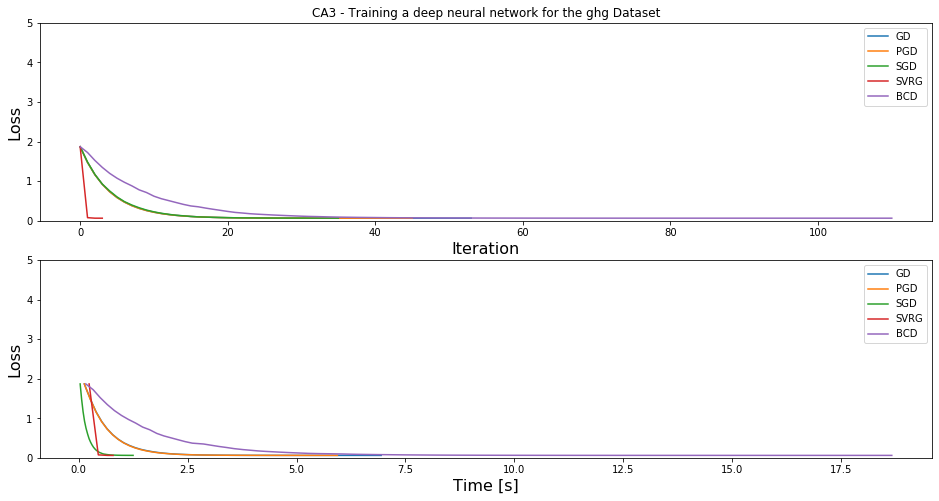

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot results
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the ghg Dataset")
ax[0].set_ylim(ymin=0, ymax=5)
ax[0].plot(np.arange(len(loss_gd)), loss_gd, label="GD")
ax[0].plot(np.arange(len(loss_pgd[:120])), loss_pgd[:120], label="PGD")
ax[0].plot(np.arange(len(loss_sgd)), loss_sgd, label="SGD")
ax[0].plot(np.arange(len(loss_svrg)), loss_svrg, label="SVRG")
ax[0].plot(np.arange(len(loss_bcd)), loss_bcd, label="BCD")
ax[0].legend()

ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Time [s]", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_ylim(ymin=0, ymax=5)
ax[1].plot(time_gd, loss_gd, label="GD")
ax[1].plot(time_pgd[:120], loss_pgd[:120], label="PGD")
ax[1].plot(time_sgd, loss_sgd, label="SGD")
ax[1].plot(time_svrg, loss_svrg, label="SVRG")
ax[1].plot(time_bcd, loss_bcd, label="BCD")
ax[1].legend()

plt.savefig("ghg-power-Loss-Iter.png")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


9
9


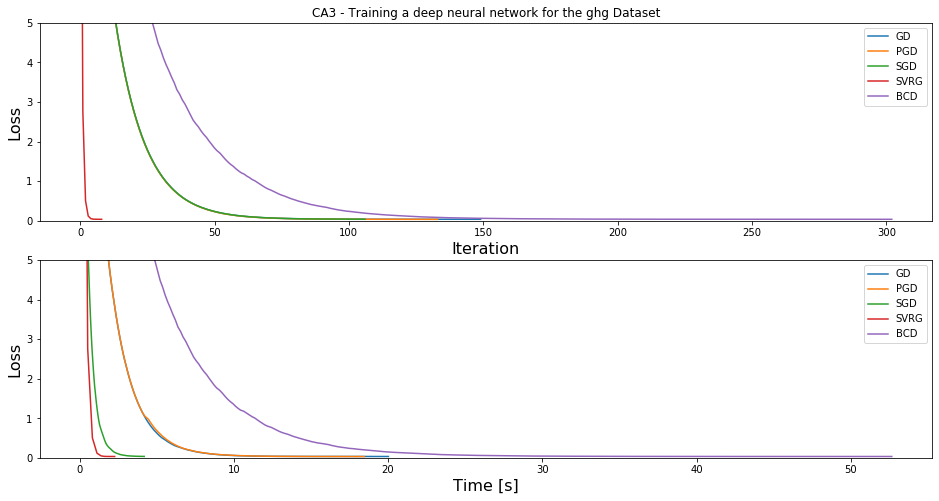

In [64]:
print(len(time_svrg1))
print(len(loss_svrg1))


fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot results
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the ghg Dataset")
ax[0].set_ylim(ymin=0, ymax=5)
ax[0].plot(np.arange(len(loss_gd1)), loss_gd1, label="GD")
ax[0].plot(np.arange(len(loss_pgd1[:280])), loss_pgd1[:280], label="PGD")
ax[0].plot(np.arange(len(loss_sgd1)), loss_sgd1, label="SGD")
ax[0].plot(np.arange(len(loss_svrg1[:10])), loss_svrg1[:10], label="SVRG")
ax[0].plot(np.arange(len(loss_bcd1)), loss_bcd1, label="BCD")
ax[0].legend()

ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Time [s]", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_ylim(ymin=0, ymax=5)
ax[1].plot(time_gd1, loss_gd1, label="GD")
ax[1].plot(time_pgd1[:280], loss_pgd1[:280], label="PGD")
ax[1].plot(time_sgd1, loss_sgd1, label="SGD")
ax[1].plot(time_svrg1, loss_svrg1[:10], label="SVRG")
ax[1].plot(time_bcd1, loss_bcd1, label="BCD")
ax[1].legend()

plt.savefig("ghg-power-Loss-Iter1.png")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


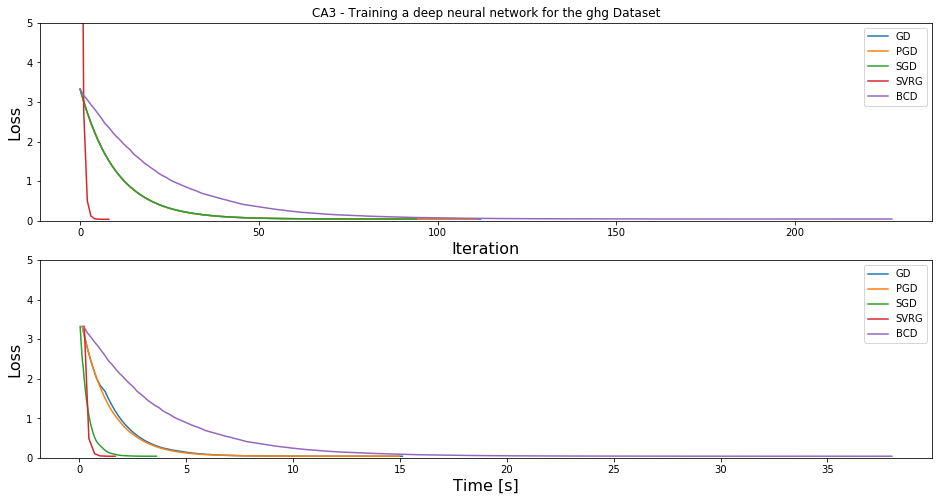

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot results
ax[0].legend(loc="upper right")
ax[0].set_xlabel(r"Iteration", fontsize=16)
ax[0].set_ylabel("Loss", fontsize=16)
ax[0].set_title("CA3 - Training a deep neural network for the ghg Dataset")
ax[0].set_ylim(ymin=0, ymax=5)
ax[0].plot(np.arange(len(loss_gd2)), loss_gd2, label="GD")
ax[0].plot(np.arange(len(loss_pgd2[:114])), loss_pgd2[:114], label="PGD")
ax[0].plot(np.arange(len(loss_sgd2)), loss_sgd2, label="SGD")
ax[0].plot(np.arange(len(loss_svrg1)), loss_svrg1, label="SVRG")
ax[0].plot(np.arange(len(loss_bcd2)), loss_bcd2, label="BCD")
ax[0].legend()

ax[1].legend(loc="upper right")
ax[1].set_xlabel(r"Time [s]", fontsize=16)
ax[1].set_ylabel("Loss", fontsize=16)
ax[1].set_ylim(ymin=0, ymax=5)
ax[1].plot(time_gd2, loss_gd2, label="GD")
ax[1].plot(time_pgd2[:114], loss_pgd2[:114], label="PGD")
ax[1].plot(time_sgd2, loss_sgd2, label="SGD")
ax[1].plot(time_svrg2, loss_svrg2, label="SVRG")
ax[1].plot(time_bcd2, loss_bcd2, label="BCD")
ax[1].legend()

plt.savefig("ghg-power-Loss-Iter2.png")

In [34]:
for i,v in enumerate(loss_pgd2):
    print(i,v)

0 13.384656425375983
1 6.379049432760934
2 3.3839310007255943
3 1.91614754103021
4 1.164734306126866
5 0.8026178635587123
6 0.6613572331771421
7 0.6389656286794283
8 0.6728562813328929
9 0.7258719026465225
10 0.7761970241195241
11 0.8118968366020131
12 0.8289603464946503
13 0.8299260301841371
14 0.821101526165619
15 0.8093192687872448
16 0.7996836831762006
17 0.7949224747804488
18 0.7958740776690824
19 0.8022619898213854
20 0.8133246000768045
21 0.8281272596883648
22 0.8460163019941604
23 0.8658122927645856
24 0.8958426941931672
25 1.1455419675155298
26 12.687262344708568
27 548.9399842093883
28 5743.694785410861
29 108.9736220282683
30 1.983185628947749
31 2.0101987589487353
32 1.7061279096606963
33 1.6739019286910894
34 1.5310258463344424
35 1.454264867464379
36 1.3319327338301379
37 1.2588425004576398
38 1.1602762316351425
39 1.1168138922963755
40 1.0395535785424743
41 1.0362224511126288
42 0.9659901211310913
43 1.0250378593556506
44 0.9490140218427376
45 1.1667704689503406
46 1.166